<a href="https://colab.research.google.com/github/Jal-E/Autonomous-Vehicle/blob/main/Road_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import sys

project_path = '/content/drive/My Drive/Data-Segementation-CPP'
os.chdir(project_path)

subdirectory_path = os.path.join(project_path, 'car_data_segmentation')
sys.path.append(subdirectory_path)


In [ ]:

!dir car_data_segmentation/


cifar10model.pth  FCN_dataset.py  FCN.py  __pycache__  unet_dataset.py	unet.py


In [ ]:
import os
import torch
import cv2
from torch.utils.data import Dataset
from torchvision import transforms


class SidewalkDataset(Dataset):
    '''
    Manages the CalPolyRoadDataset and prepares images to be processed
    '''

    def __init__(self, root, transform=None, mask_transform=None):
        self.root = root
        self.transform = transform
        self.mask_transform = mask_transform

        self.imgs = list(sorted(os.listdir(os.path.join(root, "sidewalk"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "sidewalkMask"))))

    def __getitem__(self, index):
        img_path = os.path.join(self.root, "sidewalk", self.imgs[index])
        mask_path = os.path.join(self.root, "sidewalkMask", self.masks[index])

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, 0)

        if self.transform is not None:
            img = self.transform(img)
        if self.mask_transform is not None:
            mask = self.mask_transform(mask)

        return img, mask

    def __len__(self):
        return len(self.imgs)


if __name__ == "__main__":
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    mask_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    dataset = SidewalkDataset("/content/drive/My Drive/Data-Segementation-CPP/CalPolyRoadDataset/", transform=transform, mask_transform=mask_transform)
    img, target = dataset.__getitem__(0)
    print(target)
    print(img)


tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.1490, 0.1490, 0.0902],
         [0.0000, 0.0000, 0.0000,  ..., 0.1490, 0.1490, 0.0902],
         [0.0000, 0.0000, 0.0000,  ..., 0.0980, 0.0980, 0.0627]]])
tensor([[[ 0.5707,  0.5707,  0.5707,  ...,  0.8104,  0.8276,  0.8276],
         [ 0.5707,  0.5878,  0.5707,  ...,  0.8104,  0.8104,  0.8104],
         [ 0.5878,  0.5878,  0.5878,  ...,  0.8104,  0.8104,  0.7933],
         ...,
         [-1.3815, -1.3987, -1.3644,  ..., -0.7822, -0.8164, -0.8507],
         [-1.4500, -1.4158, -1.3987,  ..., -0.7479, -0.7479, -0.7650],
         [-1.4672, -1.3815, -1.3815,  ..., -0.7479, -0.7308, -0.7308]],

        [[ 1.3431,  1.3431,  1.3256,  ...,  0.8704,  0.8880,  0.8880],
         [ 1.3431,  1.3606,  1.3256,  ...,  0.8704,  0.8704,  0.8704],
         [

### **FCN architecture**

In [ ]:
import os
import torch
import cv2
from torch.utils.data import Dataset
from torchvision import transforms
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from sklearn.model_selection import train_test_split

class SidewalkDataset(Dataset):
    def __init__(self, root, transform=None, mask_transform=None):
        self.root = root
        self.transform = transform
        self.mask_transform = mask_transform
        self.imgs = list(sorted(os.listdir(os.path.join(root, "sidewalk"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "sidewalkMask"))))

    def __getitem__(self, index):
        img_path = os.path.join(self.root, "sidewalk", self.imgs[index])
        mask_path = os.path.join(self.root, "sidewalkMask", self.masks[index])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, 0)
        if self.transform is not None:
            img = self.transform(img)
        if self.mask_transform is not None:
            mask = self.mask_transform(mask)
        return img, mask

    def __len__(self):
        return len(self.imgs)

# Function to get upsampling weight
def get_upsampling_weight(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size),
                      dtype=np.float64)
    weight[range(in_channels), range(out_channels), :, :] = filt
    return torch.from_numpy(weight).float()

class FCN32s(nn.Module):
    def __init__(self, n_class=2):
        super(FCN32s, self).__init__()
        self.conv1_1 = nn.Conv2d(3, 64, 3, padding=100)
        self.relu1_1 = nn.ReLU(inplace=True)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.relu1_2 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/2

        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.relu2_1 = nn.ReLU(inplace=True)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.relu2_2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/4

        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.relu3_1 = nn.ReLU(inplace=True)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu3_2 = nn.ReLU(inplace=True)
        self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu3_3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/8

        self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.relu4_1 = nn.ReLU(inplace=True)
        self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu4_2 = nn.ReLU(inplace=True)
        self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu4_3 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/16

        self.conv5_1 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_1 = nn.ReLU(inplace=True)
        self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_2 = nn.ReLU(inplace=True)
        self.conv5_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_3 = nn.ReLU(inplace=True)
        self.pool5 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/32

        self.fc6 = nn.Conv2d(512, 4096, 7)
        self.relu6 = nn.ReLU(inplace=True)
        self.drop6 = nn.Dropout2d()

        self.fc7 = nn.Conv2d(4096, 4096, 1)
        self.relu7 = nn.ReLU(inplace=True)
        self.drop7 = nn.Dropout2d()

        self.score_fr = nn.Conv2d(4096, n_class, 1)
        self.upscore = nn.ConvTranspose2d(n_class, n_class, 64, stride=32, bias=False)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.ConvTranspose2d):
                initial_weight = get_upsampling_weight(m.in_channels, m.out_channels, m.kernel_size[0])
                m.weight.data.copy_(initial_weight)

    def forward(self, x):
        h = x
        h = self.relu1_1(self.conv1_1(h))
        h = self.relu1_2(self.conv1_2(h))
        h = self.pool1(h)

        h = self.relu2_1(self.conv2_1(h))
        h = self.relu2_2(self.conv2_2(h))
        h = self.pool2(h)

        h = self.relu3_1(self.conv3_1(h))
        h = self.relu3_2(self.conv3_2(h))
        h = self.relu3_3(self.conv3_3(h))
        h = self.pool3(h)

        h = self.relu4_1(self.conv4_1(h))
        h = self.relu4_2(self.conv4_2(h))
        h = self.relu4_3(self.conv4_3(h))
        h = self.pool4(h)

        h = self.relu5_1(self.conv5_1(h))
        h = self.relu5_2(self.conv5_2(h))
        h = self.relu5_3(self.conv5_3(h))
        h = self.pool5(h)

        h = self.relu6(self.fc6(h))
        h = self.drop6(h)

        h = self.relu7(self.fc7(h))
        h = self.drop7(h)

        h = self.score_fr(h)

        h = self.upscore(h)
        h = h[:, :, 19:19 + x.size()[2], 19:19 + x.size()[3]].contiguous()

        return h

def dice_loss(pred, target, smooth=1.):
    pred = torch.sigmoid(pred)
    pred = pred.reshape(-1)
    target = target.reshape(-1)
    intersection = (pred * target).sum()
    return 1 - ((2. * intersection + smooth) / (pred.sum() + target.sum() + smooth))

def train_fcn():
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)
    ])

    mask_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    dataset = SidewalkDataset("/content/drive/My Drive/Data-Segementation-CPP/CalPolyRoadDataset/", transform=transform, mask_transform=mask_transform)

    train_indices, test_indices = train_test_split(list(range(len(dataset))), test_size=0.1, random_state=42)
    train_dataset = torch.utils.data.Subset(dataset, train_indices)
    test_dataset = torch.utils.data.Subset(dataset, test_indices)

    data_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=8,
        shuffle=True,
        num_workers=0,
    )

    data_loader_test = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=4,
        shuffle=False,
        num_workers=0,
    )

    H = {"train_loss": [], "test_loss": []}

    fcn = FCN32s().to('cpu')

    bce_loss = BCEWithLogitsLoss()
    def combined_loss(pred, target):
        return bce_loss(pred, target) + dice_loss(pred, target)

    opt = Adam(fcn.parameters(), lr=1e-4)  # Increased learning rate

    train_steps = len(train_dataset)
    test_steps = len(test_dataset)

    for epoch in range(30):  # Increased the number of epochs
        fcn.train()

        totalTrainLoss = 0
        totalTestLoss = 0

        for (x, y) in data_loader:
            y = y.float()
            if y.dim() == 3:
                y = y.unsqueeze(1)
            y = y.repeat(1, fcn.score_fr.out_channels, 1, 1)
            pred = fcn(x)
            loss = combined_loss(pred, y)

            opt.zero_grad()
            loss.backward()
            opt.step()

            totalTrainLoss += loss.item()

        with torch.no_grad():
            fcn.eval()
            for (x, y) in data_loader_test:
                y = y.float()
                if y.dim() == 3:
                    y = y.unsqueeze(1)
                y = y.repeat(1, fcn.score_fr.out_channels, 1, 1)
                pred = fcn(x)
                totalTestLoss += combined_loss(pred, y).item()

        avgTrainLoss = totalTrainLoss / len(data_loader)
        avgTestLoss = totalTestLoss / len(data_loader_test)

        H["train_loss"].append(avgTrainLoss)
        H["test_loss"].append(avgTestLoss)

        print(f"Epoch: {epoch + 1}, Train Loss: {avgTrainLoss}, Test Loss: {avgTestLoss}")

    plt.style.use("ggplot")
    plt.figure()
    plt.plot(H["train_loss"], label="train_loss")
    plt.plot(H["test_loss"], label="test_loss")
    plt.title("Training Loss on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="lower left")
    plt.show()

    torch.save(fcn.state_dict(), "fcn_model.pth")

def make_prediction(model, imgPath):
    model.eval()

    with torch.no_grad():
        image = cv2.imread(imgPath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.astype("float32") / 255.0

        image = cv2.resize(image, (224, 224))
        orig = image.copy()

        image = np.transpose(image, (2, 0, 1))
        image = np.expand_dims(image, 0)
        image = torch.from_numpy(image).to('cpu')

        predMask = model(image).squeeze()
        predMask = torch.sigmoid(predMask)
        predMask = predMask.cpu().numpy()
        predMask = (predMask > 0.10) * 255
        predMask = predMask.astype(np.uint8)

        if predMask.ndim == 3:
            predMask = predMask[0]

        prepare_plot(orig, predMask)

def prepare_plot(origImage, predMask):
    ogMask = cv2.imread("/content/drive/My Drive/Data-Segementation-CPP/CalPolyRoadDataset/sidewalkMask/15.png", 0)
    ogMask = cv2.resize(ogMask, ((224, 224)))

    figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
    ax[0].imshow(origImage)
    ax[1].imshow(ogMask, cmap='gray')
    ax[2].imshow(predMask, cmap='gray')
    ax[0].set_title("Image")
    ax[1].set_title("Original Mask")
    ax[2].set_title("Predicted Mask")
    figure.tight_layout()
    figure.show()
    plt.show()

def test_fcn():
    fcn = FCN32s()
    fcn.load_state_dict(torch.load("fcn_model.pth"))
    make_prediction(fcn, "/content/drive/My Drive/Data-Segementation-CPP/CalPolyRoadDataset/sidewalk/15.png")
    make_prediction(fcn, "/content/drive/My Drive/Data-Segementation-CPP/CalPolyRoadDataset/sidewalk/20.png")

if __name__ == '__main__':
    train_fcn()
    test_fcn()


Epoch: 1, Train Loss: 1.3932552072736952, Test Loss: 1.140931487083435
Epoch: 2, Train Loss: 1.1111603180567424, Test Loss: 1.094818651676178
Epoch: 3, Train Loss: 1.0771247810787625, Test Loss: 1.0824909210205078
Epoch: 4, Train Loss: 1.0715286996629503, Test Loss: 1.0806629061698914
Epoch: 5, Train Loss: 1.0610873566733465, Test Loss: 1.0837979912757874
Epoch: 6, Train Loss: 1.061973465813531, Test Loss: 1.0812683701515198
Epoch: 7, Train Loss: 1.0644206603368123, Test Loss: 1.0759989023208618
Epoch: 8, Train Loss: 1.0590278440051608, Test Loss: 1.0716097950935364
Epoch: 9, Train Loss: 1.0620796150631375, Test Loss: 1.072162687778473
Epoch: 10, Train Loss: 1.0559385617574055, Test Loss: 1.0574469566345215
Epoch: 11, Train Loss: 1.0513807932535808, Test Loss: 1.05370432138443
Epoch: 12, Train Loss: 1.052423357963562, Test Loss: 1.046673059463501
Epoch: 13, Train Loss: 1.0486238400141399, Test Loss: 1.0626545548439026
Epoch: 14, Train Loss: 1.048139598634508, Test Loss: 1.0500705242156

In [ ]:
import os
import torch
import cv2

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F

class SidewalkDataset():
    '''
        Manages the CalPolyRoadDataset and prepares images to be processed
    '''
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms

        self.imgs = list(sorted(os.listdir(os.path.join(root, "sidewalk"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "sidewalkMask"))))


    def __getitem__(self, index):

        img_path = os.path.join(self.root, "sidewalk", self.imgs[index])
        mask_path = os.path.join(self.root, "sidewalkMask", self.masks[index])

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, 0)

        if self.transforms is not None:
            img = self.transforms(img)
            mask = self.transforms(mask)

        return img, mask

    def __len__(self):
        return len(self.imgs)


if __name__ == "__main__":
    dataset = SidewalkDataset("/content/drive/My Drive/Data-Segementation-CPP/CalPolyRoadDataset/")
    img, target = dataset.__getitem__(0)
    print(target)
    print(img)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[157 193 229]
  [157 193 229]
  [157 193 229]
  ...
  [171 166 162]
  [171 166 162]
  [171 166 162]]

 [[157 193 229]
  [157 193 229]
  [157 193 229]
  ...
  [171 166 162]
  [171 166 162]
  [171 166 162]]

 [[157 193 229]
  [157 193 229]
  [157 193 229]
  ...
  [172 167 163]
  [171 166 162]
  [171 166 162]]

 ...

 [[ 25  44  51]
  [ 29  48  55]
  [ 31  48  58]
  ...
  [ 81  94 111]
  [ 80  93 110]
  [ 80  93 110]]

 [[ 29  48  55]
  [ 32  51  58]
  [ 35  52  62]
  ...
  [ 82  95 112]
  [ 82  95 112]
  [ 82  95 112]]

 [[ 32  51  58]
  [ 35  54  61]
  [ 38  55  65]
  ...
  [ 81  94 111]
  [ 81  94 111]
  [ 81  94 111]]]


# **UNET Architecture**

Epoch 1/25
Train Loss: 0.6928077340126038, Test Loss: 0.6729998350143432
Train IoU: 0.024998237668114598, Test IoU: 0.0
Train Dice: 0.047659258263593074, Test Dice: 0.0002072241622954607
Epoch 2/25
Train Loss: 0.6647817194461823, Test Loss: 0.6281707644462585
Train IoU: 0.0, Test IoU: 0.0
Train Dice: 8.5605130152544e-05, Test Dice: 0.0002072241622954607
Epoch 3/25
Train Loss: 0.6048199832439423, Test Loss: 0.3937521755695343
Train IoU: 0.0, Test IoU: 0.0
Train Dice: 8.710421752766706e-05, Test Dice: 0.0002072241622954607
Epoch 4/25
Train Loss: 0.7898977547883987, Test Loss: 0.2816720426082611
Train IoU: 0.0, Test IoU: 0.0
Train Dice: 8.532228821422905e-05, Test Dice: 0.0002072241622954607
Epoch 5/25
Train Loss: 0.37037427723407745, Test Loss: 0.4588994860649109
Train IoU: 0.0, Test IoU: 0.0
Train Dice: 8.532660285709426e-05, Test Dice: 0.0002072241622954607
Epoch 6/25
Train Loss: 0.4690413475036621, Test Loss: 0.4574807286262512
Train IoU: 0.0, Test IoU: 0.0
Train Dice: 8.5495143139269

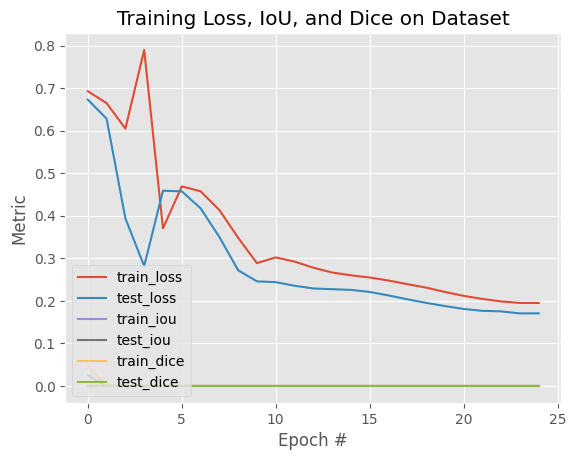

Image tensor size: torch.Size([1, 3, 224, 224])
tensor([[0.2168, 0.1330, 0.0874,  ..., 0.0895, 0.1350, 0.2642],
        [0.1142, 0.0408, 0.0222,  ..., 0.0208, 0.0444, 0.1572],
        [0.0655, 0.0199, 0.0077,  ..., 0.0076, 0.0203, 0.1077],
        ...,
        [0.0996, 0.0355, 0.0230,  ..., 0.0940, 0.1115, 0.2279],
        [0.1257, 0.0605, 0.0396,  ..., 0.1094, 0.1278, 0.2464],
        [0.2447, 0.1525, 0.1331,  ..., 0.1999, 0.2226, 0.3212]])
[[0.21680005 0.1330336  0.08735413 ... 0.08948414 0.13498625 0.26420367]
 [0.11415018 0.04075117 0.02220318 ... 0.0208432  0.0444364  0.15721183]
 [0.06546593 0.01990642 0.00770255 ... 0.00756701 0.02027404 0.10766412]
 ...
 [0.09955456 0.03552668 0.02297866 ... 0.09401301 0.11149766 0.22791009]
 [0.12572518 0.06049076 0.03962012 ... 0.1093692  0.12775412 0.24643882]
 [0.24473274 0.15252633 0.1331021  ... 0.19992833 0.22264348 0.32120538]]


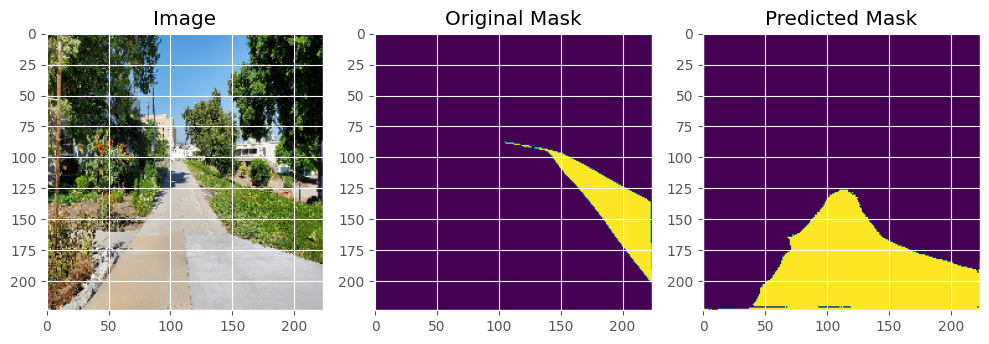

Image tensor size: torch.Size([1, 3, 224, 224])
tensor([[0.1165, 0.0381, 0.0293,  ..., 0.0110, 0.0188, 0.0761],
        [0.0462, 0.0083, 0.0060,  ..., 0.0010, 0.0022, 0.0216],
        [0.0405, 0.0073, 0.0059,  ..., 0.0006, 0.0013, 0.0152],
        ...,
        [0.0469, 0.0074, 0.0041,  ..., 0.0406, 0.0366, 0.0950],
        [0.0686, 0.0143, 0.0086,  ..., 0.0470, 0.0467, 0.1146],
        [0.1702, 0.0748, 0.0564,  ..., 0.1317, 0.1347, 0.2218]])
[[0.11654494 0.03813724 0.02925383 ... 0.0109625  0.01878976 0.07610709]
 [0.04615979 0.00833856 0.0060074  ... 0.00098465 0.00223812 0.02163975]
 [0.04050325 0.00725207 0.00588051 ... 0.00055068 0.00128953 0.01517436]
 ...
 [0.04689617 0.00741458 0.00413464 ... 0.04061894 0.03662829 0.09500713]
 [0.06861395 0.01433473 0.00856719 ... 0.04699633 0.04671356 0.11455286]
 [0.17019072 0.07475373 0.0564128  ... 0.13173182 0.13468182 0.22181076]]


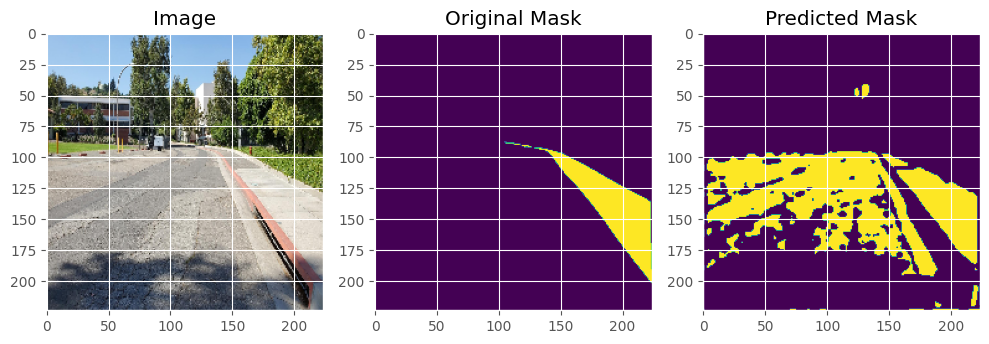

Image tensor size: torch.Size([1, 3, 224, 224])
tensor([[7.6849e-02, 1.3983e-02, 5.7021e-03,  ..., 6.4522e-03, 1.2878e-02,
         6.2994e-02],
        [1.6922e-02, 9.6061e-04, 2.2206e-04,  ..., 3.1897e-04, 9.6663e-04,
         1.3902e-02],
        [8.4193e-03, 2.9455e-04, 5.4340e-05,  ..., 1.1600e-04, 3.9771e-04,
         8.2169e-03],
        ...,
        [1.2307e-01, 5.8421e-02, 8.0073e-02,  ..., 2.6654e-04, 6.7205e-04,
         1.0495e-02],
        [1.4182e-01, 6.8635e-02, 8.1068e-02,  ..., 1.5038e-03, 2.9791e-03,
         2.5427e-02],
        [2.4256e-01, 1.6416e-01, 1.7375e-01,  ..., 2.6301e-02, 3.7514e-02,
         1.1367e-01]])
[[7.68493488e-02 1.39826452e-02 5.70205133e-03 ... 6.45221584e-03
  1.28784580e-02 6.29939660e-02]
 [1.69224553e-02 9.60612320e-04 2.22058661e-04 ... 3.18966311e-04
  9.66630352e-04 1.39016798e-02]
 [8.41933209e-03 2.94551341e-04 5.43395545e-05 ... 1.16001174e-04
  3.97713651e-04 8.21694918e-03]
 ...
 [1.23065308e-01 5.84209822e-02 8.00734833e-02 ... 2.6

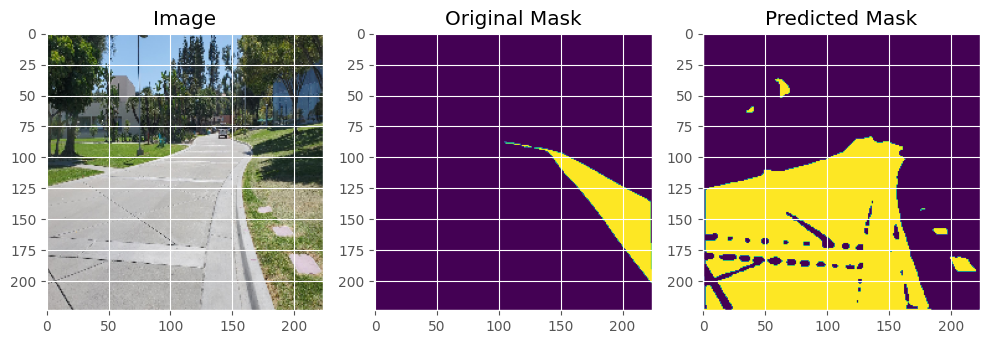

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms
import unet_dataset
import matplotlib.pyplot as plt
import cv2

from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam

# Credit for this model architecture goes to https://arxiv.org/abs/1505.04597
# https://github.com/karma218/autonomousvehiclelab/blob/main/workspaces/isaac_ros-dev/src/road_segmentation/road_segmentation/road_segmentation_node.py
# semantic segmentation

num_classes = 2


class EncoderBlock(nn.Module):
    # Consists of Conv -> ReLU -> MaxPool
    def __init__(self, in_chans, out_chans, layers=2, sampling_factor=2, padding=(1, 1)):
        super().__init__()
        self.encoder = nn.ModuleList()
        self.encoder.append(nn.Conv2d(in_chans, out_chans, 3, 1, padding=padding))
        self.encoder.append(nn.ReLU())
        for _ in range(layers - 1):
            self.encoder.append(nn.Conv2d(out_chans, out_chans, 3, 1, padding=padding))
            self.encoder.append(nn.ReLU())
        self.mp = nn.MaxPool2d(sampling_factor)

    def forward(self, x):
        # print("Encoder forward", x.shape)
        for enc in self.encoder:
            x = enc(x)
        mp_out = self.mp(x)
        return mp_out, x


class DecoderBlock(nn.Module):
    # Consists of 2x2 transposed convolution -> Conv -> relu
    def __init__(self, in_chans, out_chans, layers=2, skip_connection=True, sampling_factor=2, padding=(1, 1)):
        super().__init__()
        skip_factor = 1 if skip_connection else 2
        self.decoder = nn.ModuleList()
        self.tconv = nn.ConvTranspose2d(in_chans, in_chans // 2, sampling_factor, sampling_factor)

        self.decoder.append(nn.Conv2d(in_chans // skip_factor, out_chans, 3, 1, padding=padding))
        self.decoder.append(nn.ReLU())

        for _ in range(layers - 1):
            self.decoder.append(nn.Conv2d(out_chans, out_chans, 3, 1, padding=padding))
            self.decoder.append(nn.ReLU())

        self.skip_connection = skip_connection
        self.padding = padding

    def forward(self, x, enc_features=None):
        x = self.tconv(x)
        if self.skip_connection:
            if self.padding != (1, 1):
                # Crop the enc_features to the same size as input
                w = x.size(-1)
                c = (enc_features.size(-1) - w) // 2
                enc_features = enc_features[:, :, c:c + w, c:c + w]
            x = torch.cat((enc_features, x), dim=1)
        for dec in self.decoder:
            x = dec(x)
        return x


class UNet(nn.Module):
    def __init__(self, nclass=1, in_chans=3, depth=5, layers=2, sampling_factor=2, skip_connection=True,
                 padding=(1, 1)):
        super().__init__()
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()

        out_chans = 64
        for _ in range(depth):
            self.encoder.append(EncoderBlock(in_chans, out_chans, layers, sampling_factor, padding))
            in_chans, out_chans = out_chans, out_chans * 2

        out_chans = in_chans // 2
        for _ in range(depth - 1):
            self.decoder.append(DecoderBlock(in_chans, out_chans, layers, skip_connection, sampling_factor, padding))
            in_chans, out_chans = out_chans, out_chans // 2

        # Add a 1x1 convolution to produce final classes
        self.logits = nn.Conv2d(in_chans, nclass, 1, 1)

    def forward(self, x):
        # print("Forward shape ", x.shape)
        encoded = []
        for enc in self.encoder:
            x, enc_output = enc(x)
            encoded.append(enc_output)
        x = encoded.pop()
        for dec in self.decoder:
            enc_output = encoded.pop()
            x = dec(x, enc_output)

        # Return the logits
        # print("Logits shape ", self.logits(x).shape)
        return self.logits(x)


def iou(pred, target):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    iou = intersection / union
    return iou


def dice_coeff(pred, target):
    smooth = 1.0
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    iflat = pred.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return (2. * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth)


def train_u_net():
    '''
        Training U-Net Neural Network based on the CalPolyRoadDataset
    '''
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    train_dataset = unet_dataset.SidewalkDataset("/content/drive/My Drive/Data-Segementation-CPP/CalPolyRoadDataset/", transform)
    val_dataset = unet_dataset.SidewalkDataset("/content/drive/My Drive/Data-Segementation-CPP/CalPolyRoadDataset/", transform)

    indices = torch.randperm(len(train_dataset)).tolist()
    dataset = torch.utils.data.Subset(train_dataset, indices[:-70])
    dataset_test = torch.utils.data.Subset(val_dataset, indices[-10:])

    data_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=4,
        shuffle=True,
        num_workers=0,
    )

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test,
        batch_size=2,
        shuffle=False,
        num_workers=0,
    )

    H = {"train_loss": [], "test_loss": [], "train_iou": [], "test_iou": [], "train_dice": [], "test_dice": []}

    # Create U-Net network
    unet = UNet().to('cpu')

    # Use the BCE for loss Function
    lossFunc = BCEWithLogitsLoss()

    # Using Adam optimizers
    opt = Adam(unet.parameters(), lr=0.0005)

    num_epochs = 25

    for epoch in range(num_epochs):
        unet.train()

        totalTrainLoss = 0
        totalTestLoss = 0
        totalTrainIoU = 0
        totalTestIoU = 0
        totalTrainDice = 0
        totalTestDice = 0

        print(f"Epoch {epoch + 1}/{num_epochs}")

        for (i, (x, y)) in enumerate(data_loader):
            # Pass the image to the U-Net
            pred = unet(x)
            # Find the loss of the result and the prediction
            loss = lossFunc(pred, y)

            # Clears the gradients from the previous step
            opt.zero_grad()
            # Backpropograte through the network
            loss.backward()
            # Optimizer takes a "step"
            # Step is decided based on the learning rate
            opt.step()

            totalTrainLoss += loss.item()
            totalTrainIoU += iou(pred, y).item()
            totalTrainDice += dice_coeff(pred, y).item()

        # Don't apply gradients
        with torch.no_grad():
            unet.eval()
            for (x, y) in data_loader_test:
                pred = unet(x)
                loss = lossFunc(pred, y)
                totalTestLoss += loss.item()
                totalTestIoU += iou(pred, y).item()
                totalTestDice += dice_coeff(pred, y).item()

        avgTrainLoss = totalTrainLoss / len(data_loader)
        avgTestLoss = totalTestLoss / len(data_loader_test)
        avgTrainIoU = totalTrainIoU / len(data_loader)
        avgTestIoU = totalTestIoU / len(data_loader_test)
        avgTrainDice = totalTrainDice / len(data_loader)
        avgTestDice = totalTestDice / len(data_loader_test)

        H["train_loss"].append(avgTrainLoss)
        H["test_loss"].append(avgTestLoss)
        H["train_iou"].append(avgTrainIoU)
        H["test_iou"].append(avgTestIoU)
        H["train_dice"].append(avgTrainDice)
        H["test_dice"].append(avgTestDice)

        print(f"Train Loss: {avgTrainLoss}, Test Loss: {avgTestLoss}")
        print(f"Train IoU: {avgTrainIoU}, Test IoU: {avgTestIoU}")
        print(f"Train Dice: {avgTrainDice}, Test Dice: {avgTestDice}")

    plt.style.use("ggplot")
    plt.figure()
    plt.plot(H["train_loss"], label="train_loss")
    plt.plot(H["test_loss"], label="test_loss")
    plt.plot(H["train_iou"], label="train_iou")
    plt.plot(H["test_iou"], label="test_iou")
    plt.plot(H["train_dice"], label="train_dice")
    plt.plot(H["test_dice"], label="test_dice")
    plt.title("Training Loss, IoU, and Dice on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Metric")
    plt.legend(loc="lower left")
    plt.show()

    torch.save(unet.state_dict(), "unet_model.pth")
    make_prediction(unet, "/content/drive/My Drive/Data-Segementation-CPP/CalPolyRoadDataset/sidewalk/15.png")


# https://pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/
def make_prediction(model, imgPath):
    model.eval()

    with torch.no_grad():
        image = cv2.imread(imgPath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.astype("float32") / 255.0

        image = cv2.resize(image, (224, 224))
        orig = image.copy()

        image = np.transpose(image, (2, 0, 1))
        image = np.expand_dims(image, 0)
        image = torch.from_numpy(image).to('cpu')

        print(f"Image tensor size: {image.size()}")

        # Apply transforms to Image
        transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])

        # image = transform(image.squeeze()).unsqueeze(1)

        # make the prediction, pass the results through the sigmoid
        # function, and convert the result to a NumPy array
        predMask = model(image).squeeze()
        predMask = torch.sigmoid(predMask)
        print(predMask)
        predMask = predMask.cpu().numpy()
        # filter out the weak predictions and convert them to integers
        print(predMask)
        predMask = (predMask > 0.10) * 255
        predMask = predMask.astype(np.uint8)
        # prepare a plot for visualization
        prepare_plot(orig, predMask)


def prepare_plot(origImage, predMask):
    # initialize our figure
    ogMask = cv2.imread("/content/drive/My Drive/Data-Segementation-CPP/CalPolyRoadDataset/sidewalkMask/8.png", 0)
    ogMask = cv2.resize(ogMask, ((224, 224)))

    figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
    # plot the original image, its mask, and the predicted mask
    ax[0].imshow(origImage)
    ax[1].imshow(ogMask)
    ax[2].imshow(predMask)
    # set the titles of the subplots
    ax[0].set_title("Image")
    ax[1].set_title("Original Mask")
    ax[2].set_title("Predicted Mask")
    # set the layout of the figure and display it
    figure.tight_layout()
    figure.show()
    plt.show()


def test_unet():
    unet = UNet()

    unet.load_state_dict(torch.load("/content/drive/My Drive/Data-Segementation-CPP/CalPolyRoadDataset/cifar10model.pth"))
    make_prediction(unet, "/content/drive/My Drive/Data-Segementation-CPP/CalPolyRoadDataset/sidewalk/8.png")
    make_prediction(unet, "/content/drive/My Drive/Data-Segementation-CPP/CalPolyRoadDataset/sidewalk/10.png")


if __name__ == '__main__':
    train_u_net()
    test_unet()


**UNET (modified)**

Epoch 1/30
Train Loss: 0.6537466645240784, Test Loss: 0.6634631514549255, Train IoU: 0.0, Test IoU: 0.0
Epoch 2/30
Train Loss: 0.654226541519165, Test Loss: 0.662944233417511, Train IoU: 0.0, Test IoU: 0.0
Epoch 3/30
Train Loss: 0.6529089212417603, Test Loss: 0.6625158548355102, Train IoU: 0.0, Test IoU: 0.0
Epoch 4/30
Train Loss: 0.6531381607055664, Test Loss: 0.6620686411857605, Train IoU: 0.0, Test IoU: 0.0
Epoch 5/30
Train Loss: 0.6529482305049896, Test Loss: 0.6616516709327698, Train IoU: 0.0, Test IoU: 0.0
Epoch 6/30
Train Loss: 0.6546841263771057, Test Loss: 0.6612134218215943, Train IoU: 0.0, Test IoU: 0.0
Epoch 7/30
Train Loss: 0.6513568460941315, Test Loss: 0.6608046889305115, Train IoU: 0.0, Test IoU: 0.0
Epoch 8/30
Train Loss: 0.6505683958530426, Test Loss: 0.6603445410728455, Train IoU: 2.8729098630719818e-05, Test IoU: 0.002710908387962263
Epoch 9/30
Train Loss: 0.6497543156147003, Test Loss: 0.6597813129425049, Train IoU: 0.013538089580833912, Test IoU: 0.012994939507916

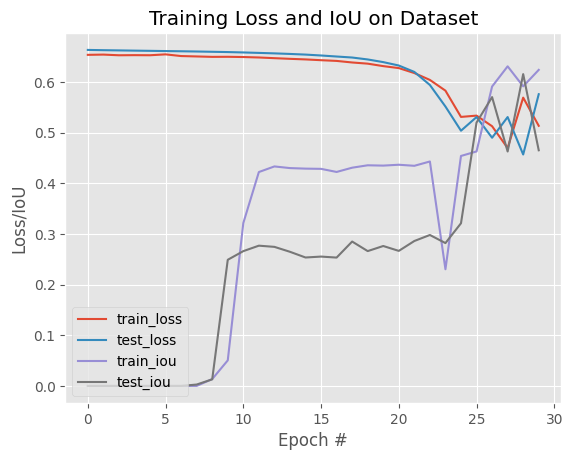

Image tensor size: torch.Size([1, 3, 224, 224])
Prediction tensor size: torch.Size([1, 1, 224, 224])
Sigmoid output: [7.6268286e-10 7.6824552e-10 7.9735407e-10 ... 7.4363488e-01 7.4387014e-01
 7.4532807e-01]


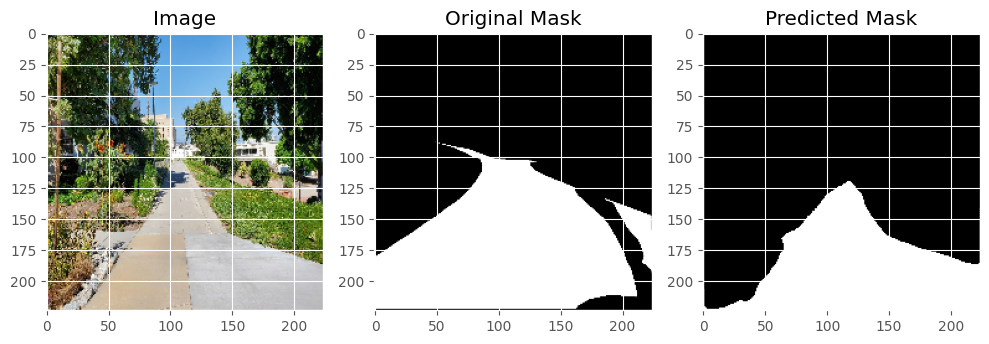

Image tensor size: torch.Size([1, 3, 224, 224])
Prediction tensor size: torch.Size([1, 1, 224, 224])
Sigmoid output: [1.7318104e-08 1.9217937e-08 1.9470006e-08 ... 7.1199268e-01 7.1286803e-01
 7.1405244e-01]


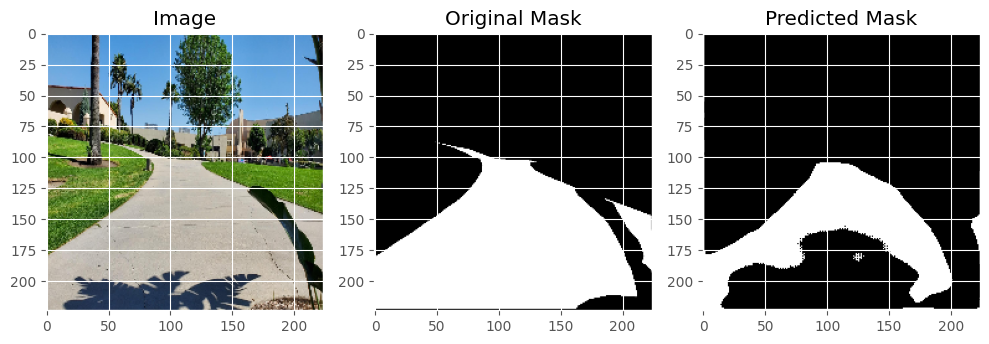

Image tensor size: torch.Size([1, 3, 224, 224])
Prediction tensor size: torch.Size([1, 1, 224, 224])
Sigmoid output: [4.8782898e-08 4.9227435e-08 5.0316267e-08 ... 6.9129682e-01 6.9150805e-01
 6.9333756e-01]


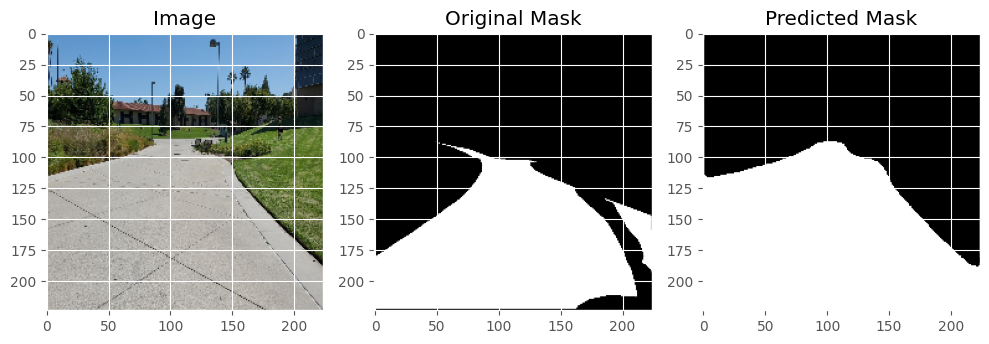

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import cv2
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, Subset
from glob import glob
import os

# Dataset Class
class SidewalkDataset(Dataset):
    def __init__(self, root_dir, transform=None, mask_transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.mask_transform = mask_transform
        self.image_paths = sorted(glob(os.path.join(root_dir, "sidewalk", "*.png")))
        self.mask_paths = sorted(glob(os.path.join(root_dir, "sidewalkMask", "*.png")))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)  # Read mask as grayscale
        mask = (mask > 0).astype(np.float32)  # Convert to binary mask

        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

# Encoder Block
class EncoderBlock(nn.Module):
    def __init__(self, in_chans, out_chans, layers=2, sampling_factor=2, padding="same"):
        super().__init__()
        self.encoder = nn.ModuleList()
        if padding == "same":
            padding = (1, 1)
        self.encoder.append(nn.Conv2d(in_chans, out_chans, 3, 1, padding=padding))
        self.encoder.append(nn.ReLU())
        for _ in range(layers - 1):
            self.encoder.append(nn.Conv2d(out_chans, out_chans, 3, 1, padding=padding))
            self.encoder.append(nn.ReLU())
        self.mp = nn.MaxPool2d(sampling_factor)

    def forward(self, x):
        for enc in self.encoder:
            x = enc(x)
        mp_out = self.mp(x)
        return mp_out, x

# Decoder Block
class DecoderBlock(nn.Module):
    def __init__(self, in_chans, out_chans, layers=2, skip_connection=True, sampling_factor=2, padding="same"):
        super().__init__()
        skip_factor = 1 if skip_connection else 2
        if padding == "same":
            padding = (1, 1)
        self.decoder = nn.ModuleList()
        self.tconv = nn.ConvTranspose2d(in_chans, in_chans // 2, sampling_factor, sampling_factor)
        self.decoder.append(nn.Conv2d(in_chans // skip_factor, out_chans, 3, 1, padding=padding))
        self.decoder.append(nn.ReLU())
        for _ in range(layers - 1):
            self.decoder.append(nn.Conv2d(out_chans, out_chans, 3, 1, padding=padding))
            self.decoder.append(nn.ReLU())
        self.skip_connection = skip_connection
        self.padding = padding

    def forward(self, x, enc_features=None):
        x = self.tconv(x)
        if self.skip_connection:
            if self.padding != (1, 1):
                w = x.size(-1)
                c = (enc_features.size(-1) - w) // 2
                enc_features = enc_features[:, :, c:c + w, c:c + w]
            x = torch.cat((enc_features, x), dim=1)
        for dec in self.decoder:
            x = dec(x)
        return x

# UNet Model
class UNet(nn.Module):
    def __init__(self, nclass=1, in_chans=3, depth=5, layers=2, sampling_factor=2, skip_connection=True, padding="same"):
        super().__init__()
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()

        out_chans = 64
        for _ in range(depth):
            self.encoder.append(EncoderBlock(in_chans, out_chans, layers, sampling_factor, padding))
            in_chans, out_chans = out_chans, out_chans * 2

        out_chans = in_chans // 2
        for _ in range(depth - 1):
            self.decoder.append(DecoderBlock(in_chans, out_chans, layers, skip_connection, sampling_factor, padding))
            in_chans, out_chans = out_chans, out_chans // 2

        self.logits = nn.Conv2d(in_chans, nclass, 1, 1)

    def forward(self, x):
        encoded = []
        for enc in self.encoder:
            x, enc_output = enc(x)
            encoded.append(enc_output)
        x = encoded.pop()
        for dec in self.decoder:
            enc_output = encoded.pop()
            x = dec(x, enc_output)
        return self.logits(x)

# Dice Loss
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, pred, target):
        smooth = 1.0
        pred = torch.sigmoid(pred)
        iflat = pred.view(-1)
        tflat = target.view(-1)
        intersection = (iflat * tflat).sum()
        return 1 - ((2. * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

# Intersection over Union (IoU)
def iou(pred, target):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    iou = intersection / union
    return iou

# Training Function
def train_u_net():
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    mask_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    train_dataset = SidewalkDataset("/content/drive/My Drive/Data-Segementation-CPP/CalPolyRoadDataset/", transform=transform, mask_transform=mask_transform)
    val_dataset = SidewalkDataset("/content/drive/My Drive/Data-Segementation-CPP/CalPolyRoadDataset/", transform=transform, mask_transform=mask_transform)

    indices = torch.randperm(len(train_dataset)).tolist()
    dataset = Subset(train_dataset, indices[:-70])
    dataset_test = Subset(val_dataset, indices[-10:])

    data_loader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0)
    data_loader_test = DataLoader(dataset_test, batch_size=2, shuffle=False, num_workers=0)

    H = {"train_loss": [], "test_loss": [], "train_iou": [], "test_iou": []}

    unet = UNet(nclass=1).to('cpu')

    bce_loss = BCEWithLogitsLoss()
    dice_loss = DiceLoss()

    def combined_loss(pred, target):
        return 0.7 * bce_loss(pred, target) + 0.3 * dice_loss(pred, target)

    opt = Adam(unet.parameters(), lr=0.00009)

    num_epochs = 30

    for epoch in range(num_epochs):
        unet.train()
        totalTrainLoss = 0
        totalTestLoss = 0
        totalTrainIoU = 0
        totalTestIoU = 0
        print(f"Epoch {epoch + 1}/{num_epochs}")

        for (x, y) in data_loader:
            pred = unet(x)
            loss = combined_loss(pred, y)
            iou_score = iou(pred, y)

            opt.zero_grad()
            loss.backward()
            opt.step()

            totalTrainLoss += loss.item()
            totalTrainIoU += iou_score.item()

        with torch.no_grad():
            unet.eval()
            for (x, y) in data_loader_test:
                pred = unet(x)
                loss = combined_loss(pred, y)
                iou_score = iou(pred, y)
                totalTestLoss += loss.item()
                totalTestIoU += iou_score.item()

        avgTrainLoss = totalTrainLoss / len(data_loader)
        avgTestLoss = totalTestLoss / len(data_loader_test)
        avgTrainIoU = totalTrainIoU / len(data_loader)
        avgTestIoU = totalTestIoU / len(data_loader_test)

        H["train_loss"].append(avgTrainLoss)
        H["test_loss"].append(avgTestLoss)
        H["train_iou"].append(avgTrainIoU)
        H["test_iou"].append(avgTestIoU)

        print(f"Train Loss: {avgTrainLoss}, Test Loss: {avgTestLoss}, Train IoU: {avgTrainIoU}, Test IoU: {avgTestIoU}")

    plt.style.use("ggplot")
    plt.figure()
    plt.plot(H["train_loss"], label="train_loss")
    plt.plot(H["test_loss"], label="test_loss")
    plt.plot(H["train_iou"], label="train_iou")
    plt.plot(H["test_iou"], label="test_iou")
    plt.title("Training Loss and IoU on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/IoU")
    plt.legend(loc="lower left")
    plt.show()

    torch.save(unet.state_dict(), "/content/drive/My Drive/Data-Segementation-CPP/CalPolyRoadDataset/unet_model.pth")
    make_prediction(unet, "/content/drive/My Drive/Data-Segementation-CPP/CalPolyRoadDataset/sidewalk/15.png")

# Prediction Function
def make_prediction(model, imgPath):
    model.eval()

    with torch.no_grad():
        image = cv2.imread(imgPath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.astype("float32") / 255.0

        image = cv2.resize(image, (224, 224))
        orig = image.copy()

        image = np.transpose(image, (2, 0, 1))
        image = np.expand_dims(image, 0)
        image = torch.from_numpy(image).to('cpu')

        print(f"Image tensor size: {image.size()}")

        # Apply transforms to Image
        transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.Lambda(lambda img: img.convert('RGB')),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        # Apply transform and make the prediction
        image = transform(image.squeeze(0).permute(1, 2, 0).numpy())
        image = image.unsqueeze(0)

        pred = model(image)
        print(f"Prediction tensor size: {pred.size()}")

        predMask = torch.sigmoid(pred).cpu().numpy().squeeze()
        print(f"Sigmoid output: {np.unique(predMask)}")

        predMask = (predMask > 0.10) * 255
        predMask = predMask.astype(np.uint8)
        prepare_plot(orig, predMask)

# Plot Function
def prepare_plot(origImage, predMask):
    ogMask = cv2.imread("/content/drive/My Drive/Data-Segementation-CPP/CalPolyRoadDataset/sidewalkMask/6.png", 0)
    ogMask = cv2.resize(ogMask, (224, 224))

    figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
    ax[0].imshow(origImage)
    ax[1].imshow(ogMask, cmap='gray')
    ax[2].imshow(predMask, cmap='gray')
    ax[0].set_title("Image")
    ax[1].set_title("Original Mask")
    ax[2].set_title("Predicted Mask")
    figure.tight_layout()
    plt.show()

# Test Function
def test_unet():
    unet = UNet(nclass=1)
    unet.load_state_dict(torch.load("/content/drive/My Drive/Data-Segementation-CPP/CalPolyRoadDataset/unet_model.pth"))
    make_prediction(unet, "/content/drive/My Drive/Data-Segementation-CPP/CalPolyRoadDataset/sidewalk/6.png")
    make_prediction(unet, "/content/drive/My Drive/Data-Segementation-CPP/CalPolyRoadDataset/sidewalk/12.png")

if __name__ == '__main__':
    train_u_net()
    test_unet()


# ***RESNET50***

Epoch [1/100], Train Loss: 2.5518, Train Accuracy: 33.41%, Val Loss: 2.5421, Val Accuracy: 36.37%
Epoch [2/100], Train Loss: 2.5232, Train Accuracy: 39.85%, Val Loss: 2.5355, Val Accuracy: 40.66%
Epoch [3/100], Train Loss: 2.4970, Train Accuracy: 45.21%, Val Loss: 2.5351, Val Accuracy: 43.21%
Epoch [4/100], Train Loss: 2.4821, Train Accuracy: 46.97%, Val Loss: 2.5007, Val Accuracy: 49.83%
Epoch [5/100], Train Loss: 2.4575, Train Accuracy: 50.73%, Val Loss: 2.5161, Val Accuracy: 51.08%
Epoch [6/100], Train Loss: 2.4351, Train Accuracy: 53.78%, Val Loss: 2.4545, Val Accuracy: 55.63%
Epoch [7/100], Train Loss: 2.4116, Train Accuracy: 54.58%, Val Loss: 2.4560, Val Accuracy: 55.23%
Epoch [8/100], Train Loss: 2.3932, Train Accuracy: 56.25%, Val Loss: 2.4388, Val Accuracy: 57.59%
Epoch [9/100], Train Loss: 2.3608, Train Accuracy: 58.22%, Val Loss: 2.4253, Val Accuracy: 57.82%
Epoch [10/100], Train Loss: 2.3564, Train Accuracy: 58.59%, Val Loss: 2.4015, Val Accuracy: 59.27%


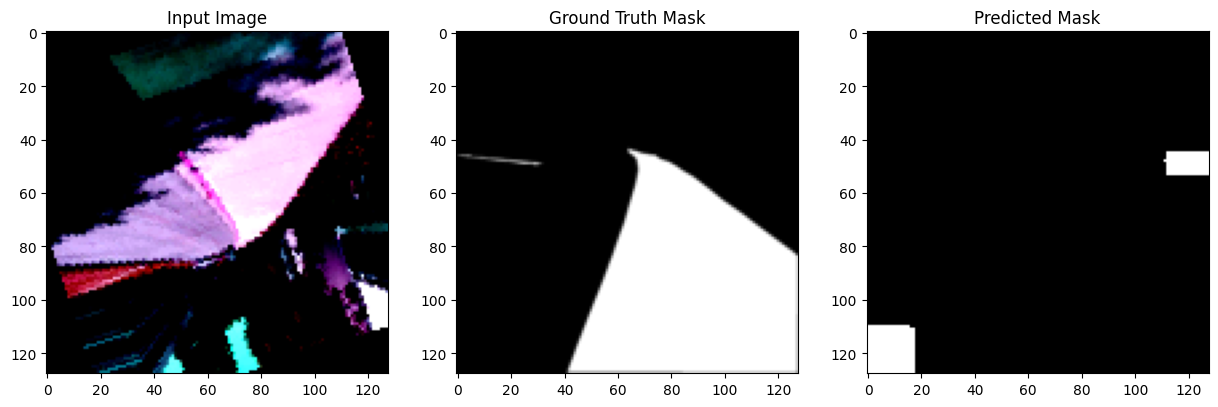

Epoch [11/100], Train Loss: 2.3264, Train Accuracy: 59.70%, Val Loss: 2.3816, Val Accuracy: 59.84%
Epoch [12/100], Train Loss: 2.3164, Train Accuracy: 59.38%, Val Loss: 2.3864, Val Accuracy: 59.61%
Epoch [13/100], Train Loss: 2.2860, Train Accuracy: 60.44%, Val Loss: 2.3474, Val Accuracy: 60.69%
Epoch [14/100], Train Loss: 2.2786, Train Accuracy: 60.52%, Val Loss: 2.3319, Val Accuracy: 61.27%
Epoch [15/100], Train Loss: 2.2559, Train Accuracy: 61.27%, Val Loss: 2.2878, Val Accuracy: 61.54%
Epoch [16/100], Train Loss: 2.2398, Train Accuracy: 60.89%, Val Loss: 2.2906, Val Accuracy: 61.67%
Epoch [17/100], Train Loss: 2.2268, Train Accuracy: 61.80%, Val Loss: 2.2747, Val Accuracy: 61.49%
Epoch [18/100], Train Loss: 2.2188, Train Accuracy: 61.66%, Val Loss: 2.2721, Val Accuracy: 61.99%
Epoch [19/100], Train Loss: 2.1991, Train Accuracy: 61.90%, Val Loss: 2.2419, Val Accuracy: 62.27%
Epoch [20/100], Train Loss: 2.1928, Train Accuracy: 62.06%, Val Loss: 2.2556, Val Accuracy: 61.89%


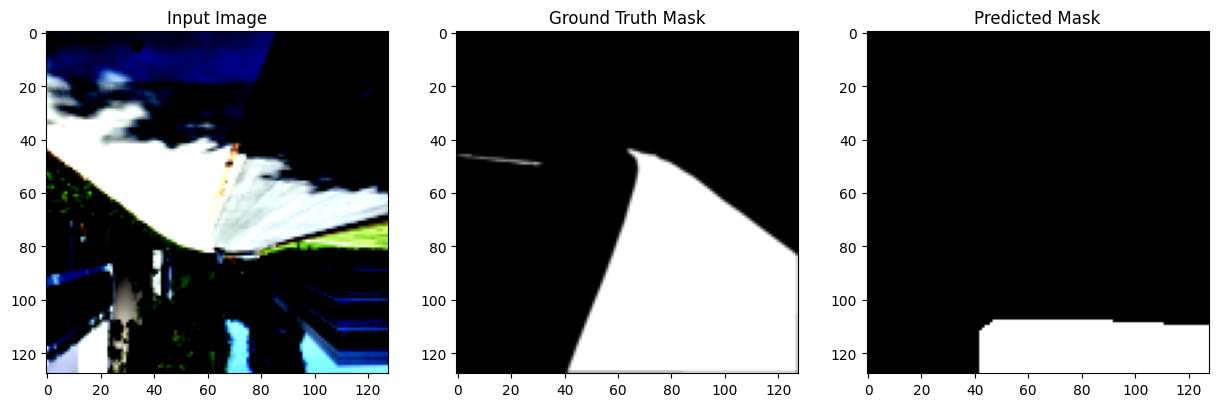

Epoch [21/100], Train Loss: 2.1837, Train Accuracy: 62.22%, Val Loss: 2.2313, Val Accuracy: 61.94%
Epoch [22/100], Train Loss: 2.1667, Train Accuracy: 62.43%, Val Loss: 2.2183, Val Accuracy: 62.43%
Epoch [23/100], Train Loss: 2.1616, Train Accuracy: 62.35%, Val Loss: 2.2261, Val Accuracy: 62.02%
Epoch [24/100], Train Loss: 2.1507, Train Accuracy: 62.44%, Val Loss: 2.2070, Val Accuracy: 62.49%
Epoch [25/100], Train Loss: 2.1398, Train Accuracy: 62.56%, Val Loss: 2.2000, Val Accuracy: 62.51%
Epoch [26/100], Train Loss: 2.1303, Train Accuracy: 62.51%, Val Loss: 2.1972, Val Accuracy: 62.46%
Epoch [27/100], Train Loss: 2.1184, Train Accuracy: 62.81%, Val Loss: 2.1831, Val Accuracy: 62.69%
Epoch [28/100], Train Loss: 2.1157, Train Accuracy: 62.73%, Val Loss: 2.1824, Val Accuracy: 62.68%
Epoch [29/100], Train Loss: 2.0997, Train Accuracy: 62.85%, Val Loss: 2.1722, Val Accuracy: 62.44%
Epoch [30/100], Train Loss: 2.1031, Train Accuracy: 62.94%, Val Loss: 2.1606, Val Accuracy: 62.98%


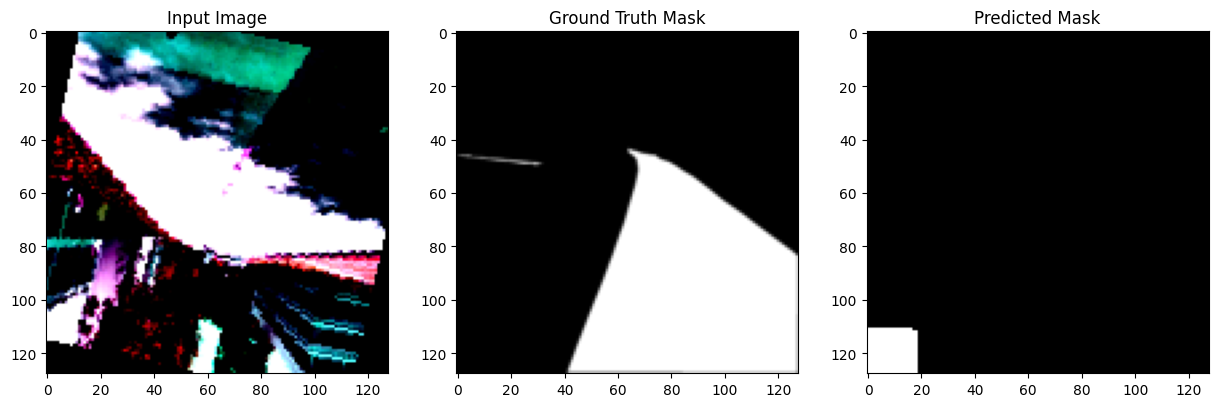

Epoch [31/100], Train Loss: 2.0934, Train Accuracy: 63.04%, Val Loss: 2.1457, Val Accuracy: 62.63%
Epoch [32/100], Train Loss: 2.0964, Train Accuracy: 62.74%, Val Loss: 2.1427, Val Accuracy: 63.00%
Epoch [33/100], Train Loss: 2.0859, Train Accuracy: 62.78%, Val Loss: 2.1408, Val Accuracy: 62.91%
Epoch [34/100], Train Loss: 2.0658, Train Accuracy: 63.09%, Val Loss: 2.1635, Val Accuracy: 62.92%
Epoch [35/100], Train Loss: 2.0712, Train Accuracy: 62.92%, Val Loss: 2.1353, Val Accuracy: 62.87%
Epoch [36/100], Train Loss: 2.0623, Train Accuracy: 62.80%, Val Loss: 2.1244, Val Accuracy: 63.04%
Epoch [37/100], Train Loss: 2.0545, Train Accuracy: 62.96%, Val Loss: 2.1750, Val Accuracy: 62.95%
Epoch [38/100], Train Loss: 2.0481, Train Accuracy: 63.00%, Val Loss: 2.1068, Val Accuracy: 63.14%
Epoch [39/100], Train Loss: 2.0402, Train Accuracy: 62.92%, Val Loss: 2.1340, Val Accuracy: 63.07%
Epoch [40/100], Train Loss: 2.0403, Train Accuracy: 63.05%, Val Loss: 2.0928, Val Accuracy: 63.18%


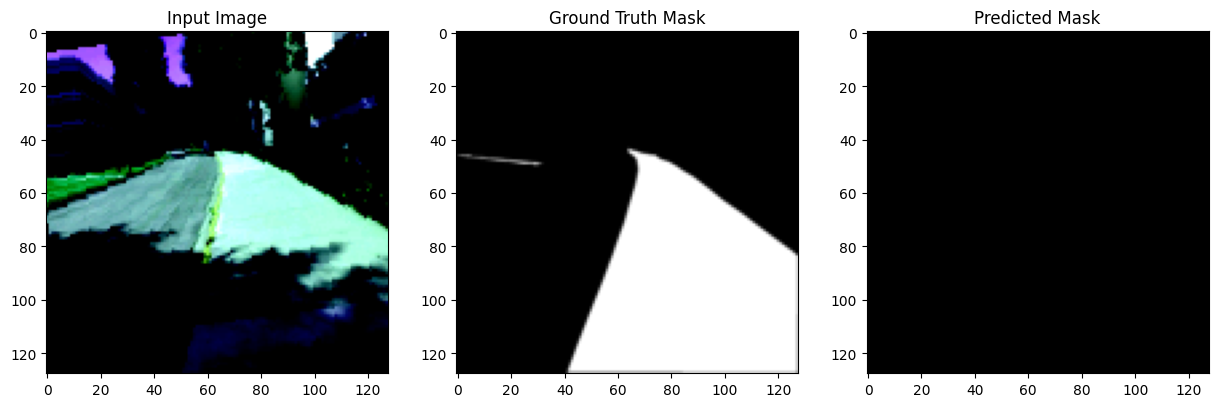

Epoch [41/100], Train Loss: 2.0463, Train Accuracy: 62.60%, Val Loss: 2.1176, Val Accuracy: 63.01%
Epoch [42/100], Train Loss: 2.0327, Train Accuracy: 63.08%, Val Loss: 2.0892, Val Accuracy: 63.09%
Epoch [43/100], Train Loss: 2.0263, Train Accuracy: 63.09%, Val Loss: 2.0918, Val Accuracy: 63.13%
Epoch [44/100], Train Loss: 2.0252, Train Accuracy: 63.06%, Val Loss: 2.0834, Val Accuracy: 63.16%
Epoch [45/100], Train Loss: 2.0253, Train Accuracy: 62.88%, Val Loss: 2.0670, Val Accuracy: 63.11%
Epoch [46/100], Train Loss: 2.0217, Train Accuracy: 63.12%, Val Loss: 2.0842, Val Accuracy: 63.21%
Epoch [47/100], Train Loss: 2.0110, Train Accuracy: 63.16%, Val Loss: 2.0668, Val Accuracy: 63.27%
Epoch [48/100], Train Loss: 2.0205, Train Accuracy: 63.07%, Val Loss: 2.1880, Val Accuracy: 63.20%
Epoch [49/100], Train Loss: 2.0168, Train Accuracy: 63.21%, Val Loss: 2.0594, Val Accuracy: 63.25%
Epoch [50/100], Train Loss: 2.0118, Train Accuracy: 63.24%, Val Loss: 2.0759, Val Accuracy: 63.24%


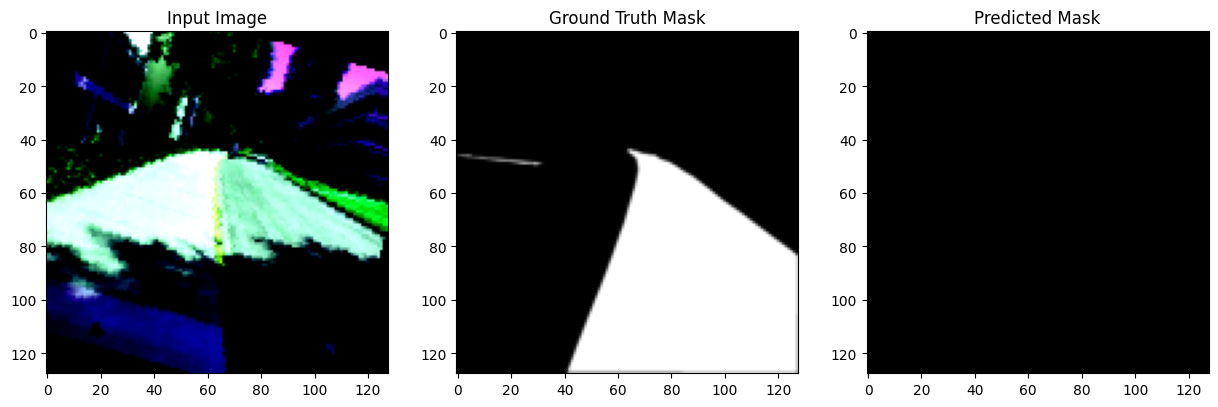

Epoch [51/100], Train Loss: 2.0060, Train Accuracy: 63.20%, Val Loss: 2.0838, Val Accuracy: 63.23%
Epoch [52/100], Train Loss: 2.0017, Train Accuracy: 63.25%, Val Loss: 2.0714, Val Accuracy: 63.29%
Epoch [53/100], Train Loss: 1.9955, Train Accuracy: 63.23%, Val Loss: 2.0759, Val Accuracy: 63.25%
Epoch [54/100], Train Loss: 1.9990, Train Accuracy: 63.26%, Val Loss: 2.0597, Val Accuracy: 63.22%
Epoch [55/100], Train Loss: 2.0058, Train Accuracy: 63.25%, Val Loss: 2.0613, Val Accuracy: 63.28%
Epoch [56/100], Train Loss: 1.9977, Train Accuracy: 63.21%, Val Loss: 2.0513, Val Accuracy: 63.29%
Epoch [57/100], Train Loss: 1.9938, Train Accuracy: 63.15%, Val Loss: 2.1045, Val Accuracy: 63.27%
Epoch [58/100], Train Loss: 2.0026, Train Accuracy: 63.26%, Val Loss: 2.0555, Val Accuracy: 63.24%
Epoch [59/100], Train Loss: 1.9979, Train Accuracy: 63.26%, Val Loss: 2.0608, Val Accuracy: 63.28%
Epoch [60/100], Train Loss: 1.9945, Train Accuracy: 63.25%, Val Loss: 2.0256, Val Accuracy: 63.24%


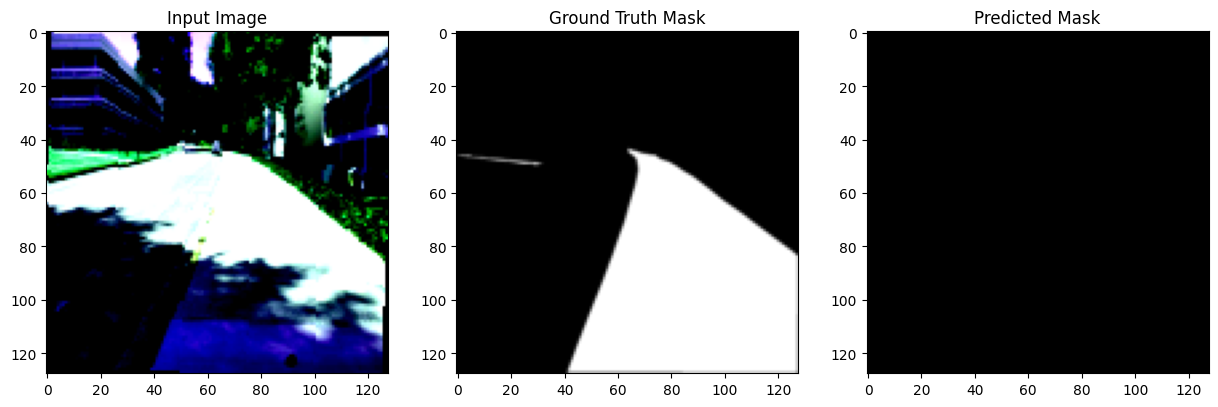

Epoch [61/100], Train Loss: 1.9952, Train Accuracy: 63.22%, Val Loss: 2.0380, Val Accuracy: 63.31%
Epoch [62/100], Train Loss: 1.9950, Train Accuracy: 63.24%, Val Loss: 2.0633, Val Accuracy: 63.23%
Epoch [63/100], Train Loss: 1.9976, Train Accuracy: 63.24%, Val Loss: 2.0822, Val Accuracy: 63.25%
Epoch [64/100], Train Loss: 1.9972, Train Accuracy: 63.11%, Val Loss: 2.0341, Val Accuracy: 63.30%
Epoch [65/100], Train Loss: 1.9931, Train Accuracy: 63.12%, Val Loss: 2.0377, Val Accuracy: 63.27%
Epoch [66/100], Train Loss: 1.9951, Train Accuracy: 63.27%, Val Loss: 2.0374, Val Accuracy: 63.23%
Epoch [67/100], Train Loss: 1.9987, Train Accuracy: 63.23%, Val Loss: 2.0344, Val Accuracy: 63.23%
Epoch [68/100], Train Loss: 1.9893, Train Accuracy: 63.21%, Val Loss: 2.0397, Val Accuracy: 63.28%
Epoch [69/100], Train Loss: 1.9914, Train Accuracy: 63.21%, Val Loss: 2.0651, Val Accuracy: 63.31%
Epoch [70/100], Train Loss: 1.9874, Train Accuracy: 63.23%, Val Loss: 2.0490, Val Accuracy: 63.29%


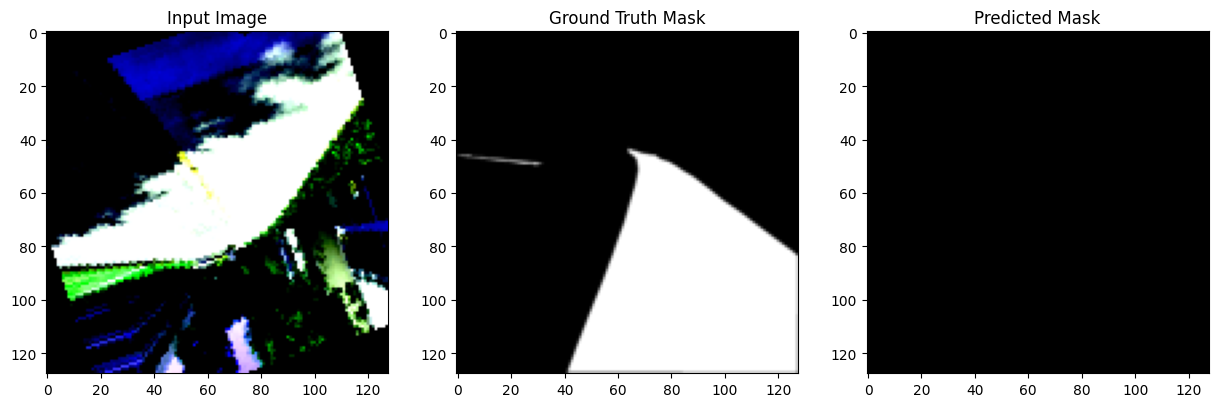

Epoch [71/100], Train Loss: 1.9950, Train Accuracy: 63.22%, Val Loss: 2.0844, Val Accuracy: 63.26%
Epoch [72/100], Train Loss: 1.9870, Train Accuracy: 63.27%, Val Loss: 2.0578, Val Accuracy: 63.29%
Epoch [73/100], Train Loss: 1.9953, Train Accuracy: 63.24%, Val Loss: 2.0451, Val Accuracy: 63.27%
Epoch [74/100], Train Loss: 1.9859, Train Accuracy: 63.28%, Val Loss: 2.0658, Val Accuracy: 63.22%
Epoch [75/100], Train Loss: 1.9894, Train Accuracy: 63.28%, Val Loss: 2.0347, Val Accuracy: 63.29%
Epoch [76/100], Train Loss: 1.9894, Train Accuracy: 63.21%, Val Loss: 2.0439, Val Accuracy: 63.28%
Epoch [77/100], Train Loss: 1.9926, Train Accuracy: 63.24%, Val Loss: 2.0324, Val Accuracy: 63.31%
Epoch [78/100], Train Loss: 1.9870, Train Accuracy: 63.27%, Val Loss: 2.0998, Val Accuracy: 63.27%
Epoch [79/100], Train Loss: 1.9894, Train Accuracy: 63.29%, Val Loss: 2.0433, Val Accuracy: 63.26%
Epoch [80/100], Train Loss: 1.9845, Train Accuracy: 63.25%, Val Loss: 2.0256, Val Accuracy: 63.31%


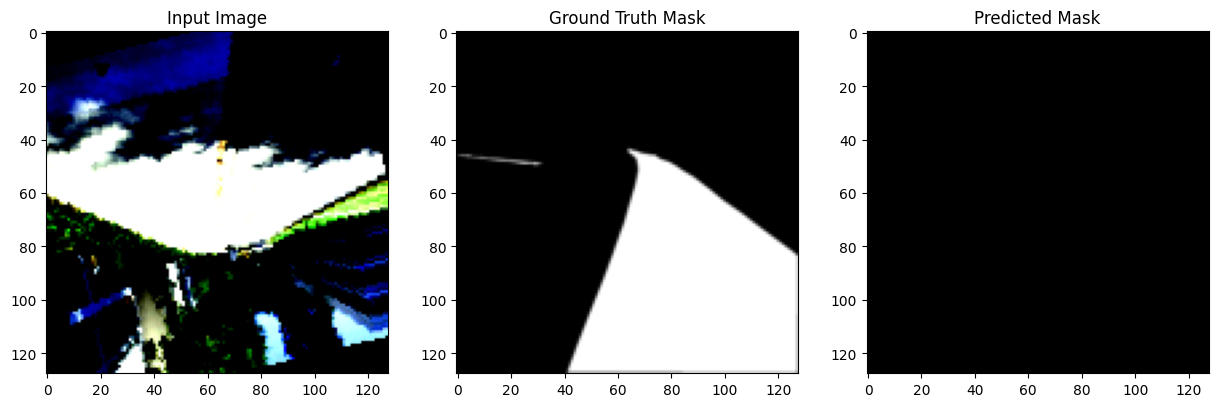

Epoch [81/100], Train Loss: 1.9936, Train Accuracy: 63.18%, Val Loss: 2.0457, Val Accuracy: 63.31%
Epoch [82/100], Train Loss: 1.9863, Train Accuracy: 63.30%, Val Loss: 2.0477, Val Accuracy: 63.27%
Epoch [83/100], Train Loss: 1.9906, Train Accuracy: 63.24%, Val Loss: 2.0310, Val Accuracy: 63.31%
Epoch [84/100], Train Loss: 1.9840, Train Accuracy: 63.27%, Val Loss: 2.0642, Val Accuracy: 63.25%
Epoch [85/100], Train Loss: 1.9863, Train Accuracy: 63.20%, Val Loss: 2.0292, Val Accuracy: 63.30%
Epoch [86/100], Train Loss: 1.9848, Train Accuracy: 63.22%, Val Loss: 2.1707, Val Accuracy: 63.23%
Epoch [87/100], Train Loss: 1.9907, Train Accuracy: 63.24%, Val Loss: 2.0303, Val Accuracy: 63.27%
Epoch [88/100], Train Loss: 1.9867, Train Accuracy: 63.23%, Val Loss: 2.0408, Val Accuracy: 63.31%
Epoch [89/100], Train Loss: 1.9881, Train Accuracy: 63.28%, Val Loss: 2.0309, Val Accuracy: 63.28%
Epoch [90/100], Train Loss: 1.9858, Train Accuracy: 63.30%, Val Loss: 2.0158, Val Accuracy: 63.31%


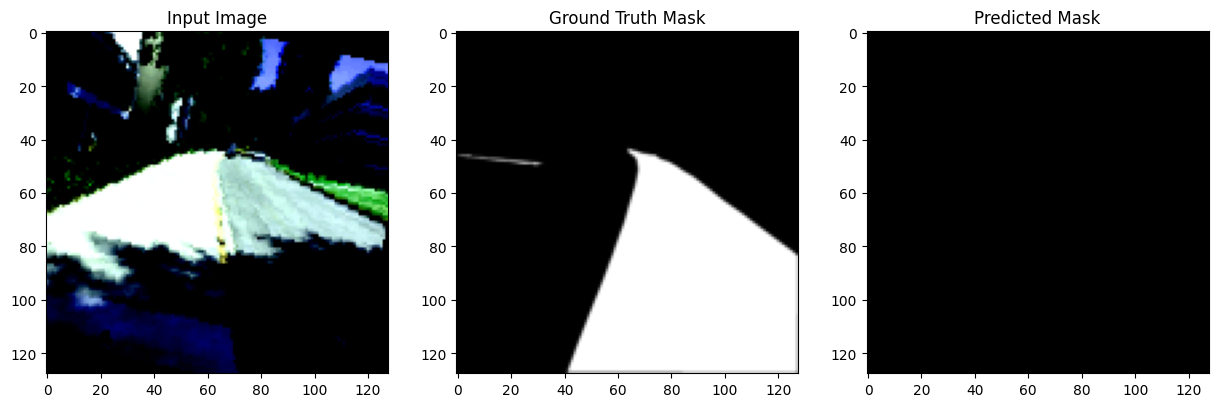

Epoch [91/100], Train Loss: 1.9963, Train Accuracy: 63.27%, Val Loss: 2.0861, Val Accuracy: 63.29%
Epoch [92/100], Train Loss: 1.9955, Train Accuracy: 63.30%, Val Loss: 2.0229, Val Accuracy: 63.29%
Epoch [93/100], Train Loss: 1.9854, Train Accuracy: 63.21%, Val Loss: 2.0222, Val Accuracy: 63.28%
Epoch [94/100], Train Loss: 1.9923, Train Accuracy: 63.23%, Val Loss: 2.0269, Val Accuracy: 63.29%
Epoch [95/100], Train Loss: 1.9955, Train Accuracy: 63.30%, Val Loss: 2.0296, Val Accuracy: 63.27%
Epoch [96/100], Train Loss: 1.9905, Train Accuracy: 63.22%, Val Loss: 2.0352, Val Accuracy: 63.30%
Epoch [97/100], Train Loss: 1.9847, Train Accuracy: 63.31%, Val Loss: 2.0401, Val Accuracy: 63.24%
Epoch [98/100], Train Loss: 1.9859, Train Accuracy: 63.27%, Val Loss: 2.0270, Val Accuracy: 63.28%
Epoch [99/100], Train Loss: 1.9865, Train Accuracy: 63.28%, Val Loss: 2.0575, Val Accuracy: 63.27%
Epoch [100/100], Train Loss: 1.9936, Train Accuracy: 63.16%, Val Loss: 2.0209, Val Accuracy: 63.29%


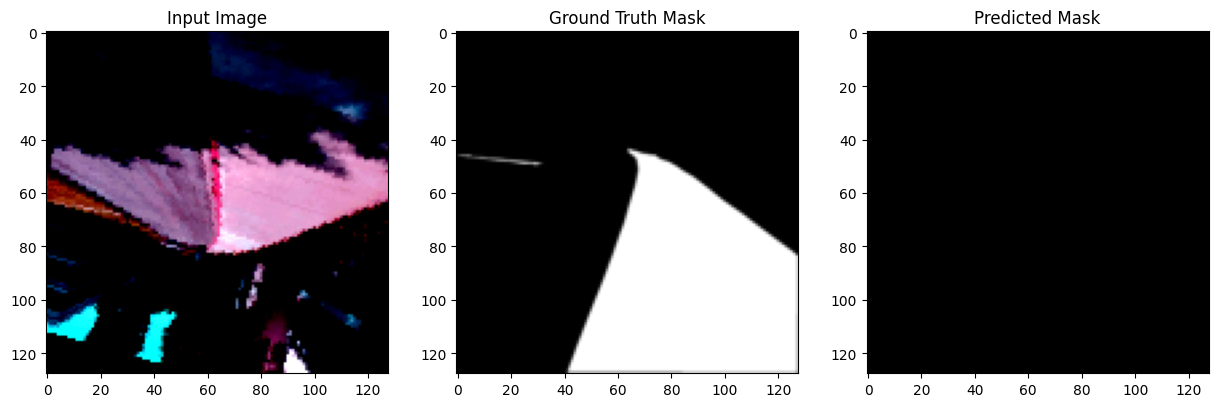

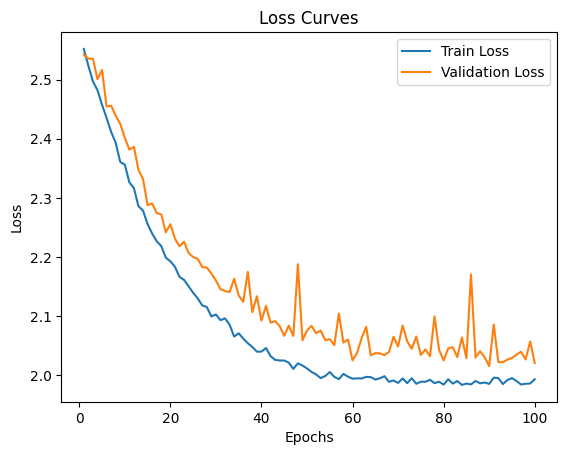

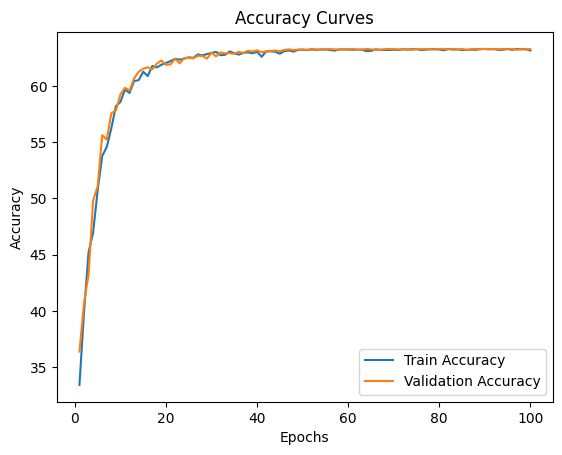

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import cv2
from torch.utils.data import Dataset

# SidewalkDataset class definition
class SidewalkDataset(Dataset):
    def __init__(self, root, transform=None, mask_transform=None):
        self.root = root
        self.transform = transform
        self.mask_transform = mask_transform

        self.imgs = list(sorted(os.listdir(os.path.join(root, "sidewalk"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "sidewalkMask"))))

    def __getitem__(self, index):
        img_path = os.path.join(self.root, "sidewalk", self.imgs[index])
        mask_path = os.path.join(self.root, "sidewalkMask", self.masks[index])

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, 0)

        if self.transform is not None:
            img = self.transform(img)
        if self.mask_transform is not None:
            mask = self.mask_transform(mask)

        return img, mask

    def __len__(self):
        return len(self.imgs)

# Dice Loss function
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth) / (inputs.sum() + targets.sum() + smooth)

        return 1 - dice

# IoU Loss function
class IoULoss(nn.Module):
    def __init__(self):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection

        IoU = (intersection + smooth) / (union + smooth)

        return 1 - IoU

# Define the ResNet50 based model for your project
class ResNet50Segmentation(nn.Module):
    def __init__(self, num_classes=1):
        super(ResNet50Segmentation, self).__init__()
        self.backbone = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

        # Remove the fully connected layer and avgpool layer
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-2])

        # Add a dropout layer
        self.dropout = nn.Dropout(p=0.5)

        # Add a convolutional layer to adjust the number of classes
        self.conv = nn.Conv2d(2048, num_classes, kernel_size=1)

        # Add an upsampling layer to match the input size
        self.upsample = nn.Upsample(scale_factor=32, mode='bilinear', align_corners=False)

    def forward(self, x):
        x = self.backbone(x)
        x = self.dropout(x)
        x = self.conv(x)
        x = self.upsample(x)
        return x

# Function to load your dataset
def load_dataset(data_path):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((128, 128)),  # Reduced input size
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Data augmentation
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(degrees=20),  # More data augmentation
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    mask_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((128, 128)),  # Reduced input size
        transforms.ToTensor()
    ])

    train_dataset = SidewalkDataset(data_path, transform=transform, mask_transform=mask_transform)
    val_dataset = SidewalkDataset(data_path, transform=transform, mask_transform=mask_transform)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=2)

    return train_loader, val_loader

# Function to plot predictions
def plot_predictions(model, dataloader, device, num_images=1):
    model.eval()
    images_so_far = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()

            outputs = model(inputs)
            preds = torch.sigmoid(outputs) > 0.5

            for j in range(inputs.size()[0]):
                images_so_far += 1
                if images_so_far > num_images:
                    return

                plt.figure(figsize=(15, 5))

                plt.subplot(1, 3, 1)
                plt.imshow(inputs.cpu().data[j].permute(1, 2, 0))
                plt.title('Input Image')

                plt.subplot(1, 3, 2)
                plt.imshow(labels.cpu().data[j].squeeze(), cmap='gray')
                plt.title('Ground Truth Mask')

                plt.subplot(1, 3, 3)
                plt.imshow(preds.cpu().data[j].squeeze(), cmap='gray')
                plt.title('Predicted Mask')

                plt.show()

# Training function with combined loss and visualization
def train_model(model, train_loader, val_loader, num_epochs=30, learning_rate=0.00001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.BCEWithLogitsLoss()
    dice_loss = DiceLoss()
    iou_loss = IoULoss()

    def combined_loss(pred, target):
        return criterion(pred, target) + dice_loss(pred, target) + iou_loss(pred, target)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss, correct_train = 0.0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = combined_loss(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            preds = torch.sigmoid(outputs) > 0.5
            correct_train += torch.sum(preds == labels.data)

        train_loss /= len(train_loader.dataset)
        train_accuracy = 100.0 * correct_train.double() / (len(train_loader.dataset) * 128 * 128)  # Adjust for pixel-wise accuracy

        model.eval()
        val_loss, correct_val = 0.0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).float()
                outputs = model(inputs)
                loss = combined_loss(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                preds = torch.sigmoid(outputs) > 0.5
                correct_val += torch.sum(preds == labels.data)

        val_loss /= len(val_loader.dataset)
        val_accuracy = 100.0 * correct_val.double() / (len(val_loader.dataset) * 128 * 128)  # Adjust for pixel-wise accuracy

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy.item())
        val_accuracies.append(val_accuracy.item())

        scheduler.step(val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        # Plot predictions at the end of each epoch
        if (epoch + 1) % 10 == 0:  # Change the interval as needed
            plot_predictions(model, val_loader, device, num_images=1)

    return model, train_losses, val_losses, train_accuracies, val_accuracies

# Plotting the results
def plot_results(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure()
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curves')
    plt.show()

    plt.figure()
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Curves')
    plt.show()

# Main function to train and evaluate the model
if __name__ == '__main__':
    data_path = "/content/drive/My Drive/Data-Segementation-CPP/CalPolyRoadDataset/"
    train_loader, val_loader = load_dataset(data_path)

    resnet50_model = ResNet50Segmentation(num_classes=1)  # For binary segmentation, num_classes=1
    trained_model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(resnet50_model, train_loader, val_loader, num_epochs=100, learning_rate=0.00001)

    plot_results(train_losses, val_losses, train_accuracies, val_accuracies)
    torch.save(trained_model.state_dict(), "resnet50_av_model.pth")
